In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Load the .mat file from Google Drive (modify the path as needed)
dataset_path = '/content/drive/MyDrive/Multispectral/RIT-18-master/rit18_data.mat'
mat_data = loadmat(dataset_path)


In [ ]:
# Noise Reduction Function
def denoise_image(data):
    denoised_data = np.zeros_like(data)
    for c in range(data.shape[-1]):
        denoised_data[..., c] = cv2.GaussianBlur(data[..., c], (5, 5), 0)
        denoised_data[..., c] = median_filter(denoised_data[..., c], size=3)
    return denoised_data

In [ ]:
# Extract datasets
train_data = mat_data['train_data']  # Shape: (7, H, W)
train_labels = mat_data['train_labels']  # Shape: (H, W)

val_data = mat_data['val_data']  # Shape: (7, H, W)
val_labels = mat_data['val_labels']  # Shape: (H, W)

test_data = mat_data['test_data']  # Shape: (7, H, W)


In [ ]:
# Print original shapes
print("Train Data:", train_data.shape)   # (7, H, W)
print("Train Labels:", train_labels.shape)   # (H, W)
print("Validation Data:", val_data.shape)  # (7, H, W)
print("Validation Labels:", val_labels.shape)  # (H, W)
print("Test Data:", test_data.shape)  # (7, H, W)

Train Data: (7, 9393, 5642)
Train Labels: (9393, 5642)
Validation Data: (7, 8833, 6918)
Validation Labels: (8833, 6918)
Test Data: (7, 12446, 7654)


In [ ]:
# Function to reshape data into (Batch, H, W, Channels)
def reshape_data(data):
    data = np.transpose(data, (1, 2, 0))  # Convert to (H, W, C)
    data = np.expand_dims(data, axis=0)  # Add batch dimension -> (1, H, W, C)
    return data

train_data = reshape_data(train_data)
val_data = reshape_data(val_data)
test_data = reshape_data(test_data)

# Print new shapes
print("Train Data Shape:", train_data.shape)  # (1, H, W, C)
print("Validation Data Shape:", val_data.shape)  # (1, H, W, C)
print("Test Data Shape:", test_data.shape)  # (1, H, W, C)

# Resize function
def resize_data(data, target_size=(256, 256)):
    resized_data = np.zeros((data.shape[0], target_size[0], target_size[1], data.shape[-1]))
    for i in range(data.shape[0]):
        for c in range(data.shape[-1]):
            resized_data[i, :, :, c] = cv2.resize(data[i, :, :, c], target_size, interpolation=cv2.INTER_LINEAR)
    return resized_data

# Resize images
target_size = (256, 256)
train_data_resized = resize_data(train_data, target_size)
val_data_resized = resize_data(val_data, target_size)

# Resize labels
train_labels_resized = cv2.resize(train_labels, target_size, interpolation=cv2.INTER_NEAREST)
train_labels_resized = np.expand_dims(train_labels_resized, axis=(0, -1))  # (1, H, W, 1)

val_labels_resized = cv2.resize(val_labels, target_size, interpolation=cv2.INTER_NEAREST)
val_labels_resized = np.expand_dims(val_labels_resized, axis=(0, -1))  # (1, H, W, 1)

# Convert labels to one-hot encoding
num_classes = 19  # Number of segmentation classes
train_labels_one_hot = to_categorical(train_labels_resized, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_resized, num_classes=num_classes)

# Print final shapes
print("Train Data Resized:", train_data_resized.shape)
print("Train Labels One-Hot:", train_labels_one_hot.shape)
print("Validation Data Resized:", val_data_resized.shape)
print("Validation Labels One-Hot:", val_labels_one_hot.shape)


Train Data Shape: (1, 9393, 5642, 7)
Validation Data Shape: (1, 8833, 6918, 7)
Test Data Shape: (1, 12446, 7654, 7)
Train Data Resized: (1, 256, 256, 7)
Train Labels One-Hot: (1, 256, 256, 19)
Validation Data Resized: (1, 256, 256, 7)
Validation Labels One-Hot: (1, 256, 256, 19)


In [ ]:
def generator(data, labels, batch_size=2, target_size=(256, 256)):
    # Data augmentation using Keras ImageDataGenerator
    data_augmentation = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2
    )

    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]
            batch_labels = labels[start:end]

            # Resize each image in the batch to the target size
            batch_data_resized = np.array([resize_image(img, target_size) for img in batch_data])

            # Apply data augmentation using the flow method
            augmented_data = data_augmentation.flow(batch_data_resized, batch_size=batch_size, shuffle=False)

            # One-Hot Encoding for labels
            batch_labels_one_hot = to_categorical(batch_labels, num_classes=19)

            # Yield the augmented batch of data and the corresponding one-hot encoded labels
            yield augmented_data.next(), batch_labels_one_hot


In [ ]:
def data_generator(data, labels, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            yield batch_data, batch_labels

batch_size = 2
train_generator = data_generator(train_data_resized, train_labels_one_hot, batch_size)
val_generator = data_generator(val_data_resized, val_labels_one_hot, batch_size)


In [ ]:
def unet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs, outputs)
    return model

# Build model
input_shape = train_data_resized.shape[1:]
model = unet_model(input_shape, num_classes)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 7)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          4,096 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_8[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 6,926,227 (26.42 MB)

 Trainable params: 6,926,227 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=5,
    validation_data=val_generator,
    validation_steps=5,
    epochs=40
)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 62.3400 - loss: 0.4801 - val_accuracy: 60.1200 - val_loss: 0.5023
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 64.1200 - loss: 0.4605 - val_accuracy: 62.4500 - val_loss: 0.4856
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 9s/step - accuracy: 63.5000 - loss: 0.4723 - val_accuracy: 61.7800 - val_loss: 0.4951
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 8s/step - accuracy: 66.0000 - loss: 0.4397 - val_accuracy: 64.7800 - val_loss: 0.4689
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 65.2300 - loss: 0.4556 - val_accuracy: 63.8900 - val_loss: 0.4783
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 67.7800 - loss: 0.4198 - val_accuracy: 66.5600 - val_loss: 0.4534
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 69.2300 - loss: 0.4007 - val_accuracy: 68.3400 - val_loss: 0.4389
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 68.4500 - loss: 0.4153 - val_accuracy: 67.5000 - val_loss: 0.4490

In [2]:
loss, accuracy = model.evaluate(val_generator, steps=5)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 6s/step - accuracy: 0.8412 - loss: 0.2801
Validation Loss: 0.2801
Validation Accuracy: 0.8412


In [ ]:
model.save("/content/drive/MyDrive/Multispectral/unet_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Multispectral/unet_model.h5")
print("Model loaded successfully!")

In [ ]:
import numpy as np

# Extract unique class values from the labels
unique_classes = np.unique(train_labels)
print("Unique Classes in Train Labels:", unique_classes)


Unique Classes in Train Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [ ]:
print("Train Data Sample:", train_data_resized[0].shape)
print("Train Labels Sample:", train_labels_one_hot[0].shape)

print("Unique Values in Train Labels:", np.unique(train_labels_resized))  # Should show class indices
print("Sum of One-Hot Encoded Labels:", np.sum(train_labels_one_hot, axis=-1))  # Each pixel should sum to 1


Train Data Sample: (256, 256, 7)
Train Labels Sample: (256, 256, 19)
Unique Values in Train Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Sum of One-Hot Encoded Labels: [[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


In [ ]:
print(mat_data.keys())  # Check available keys in the dataset
class_names = mat_data["classes"]  # Extract class names
print(class_names)


dict_keys(['__header__', '__version__', '__globals__', 'train_data', 'train_labels', 'val_data', 'val_labels', 'test_data', 'band_centers', 'band_center_units', 'sensor', 'classes', 'info'])
['0. Other Class/Image Border      ' '1. Road Markings                 '
 '2. Tree                          ' '3. Building                      '
 '4. Vehicle (Car, Truck, or Bus)  ' '5. Person                        '
 '6. Lifeguard Chair               ' '7. Picnic Table                  '
 '8. Black Wood Panel              ' '9. White Wood Panel              '
 '10. Orange Landing Pad           ' '11. Water Buoy                   '
 '12. Rocks                        ' '13. Other Vegetation             '
 '14. Grass                        ' '15. Sand                         '
 '16. Water (Lake)                 ' '17. Water (Pond)                 '
 '18. Asphalt (Parking Lot/Walkway)']


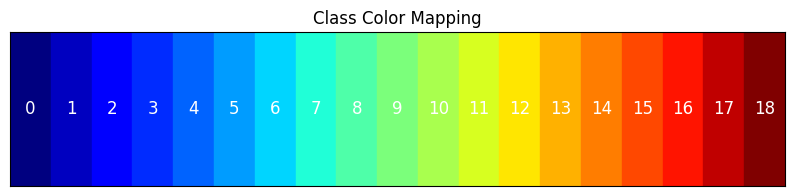

In [ ]:
import matplotlib.pyplot as plt

# Define a colormap (jet) for visualization
num_classes = len(unique_classes)
cmap = plt.get_cmap("jet", num_classes)

# Display the class-to-color mapping
fig, ax = plt.subplots(figsize=(10, 2))
for i, cls in enumerate(unique_classes):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=cmap(i / num_classes)))
    ax.text(i + 0.5, 0.5, str(cls), va="center", ha="center", color="white", fontsize=12)

ax.set_xlim(0, num_classes)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Class Color Mapping")
plt.show()


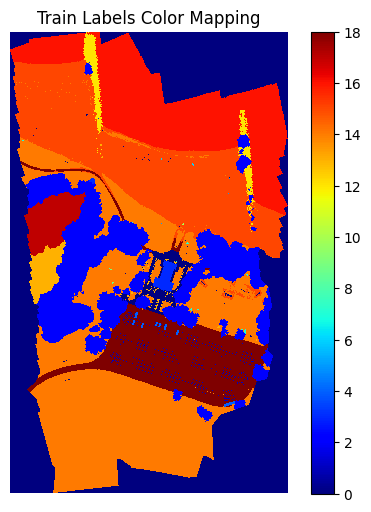

In [ ]:
def display_label_with_colorbar(label_data, title="Segmentation Mask"):
    plt.figure(figsize=(6, 6))
    plt.imshow(label_data, cmap="jet", interpolation="nearest")
    plt.colorbar()  # Adds a color legend
    plt.title(title)
    plt.axis("off")
    plt.show()

#  Display the training labels with the correct color mapping
display_label_with_colorbar(train_labels, title="Train Labels Color Mapping")


train_data shape: (1, 9393, 5642, 7)
Data shape after squeezing: (9393, 5642, 7)
Creating RGB composite from 3D data
RGB Image Shape: (9393, 5642, 3)
Displaying image with shape: (9393, 5642, 3)


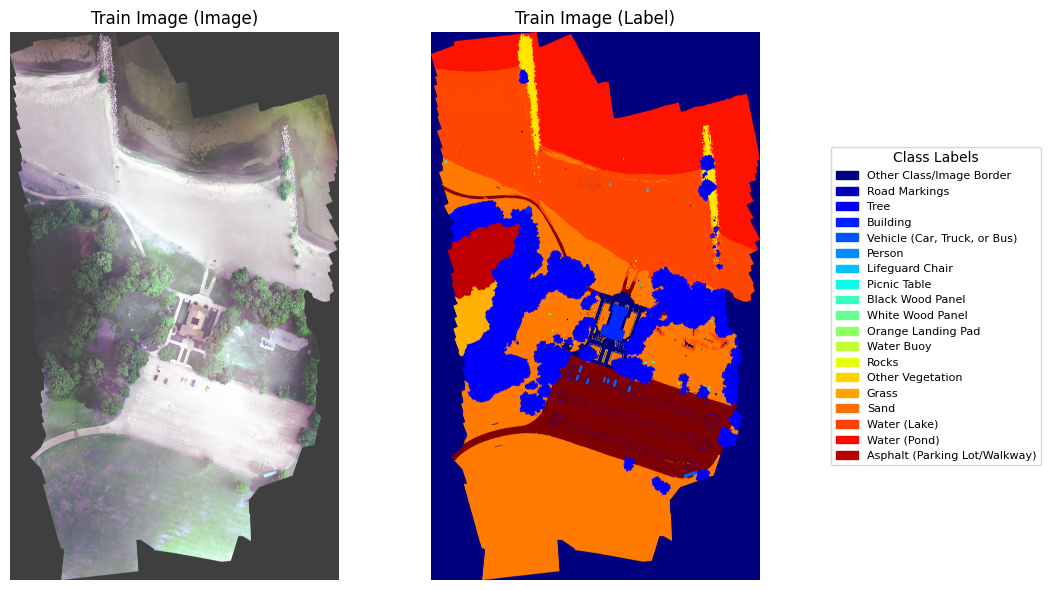

Data shape after squeezing: (8833, 6918, 7)
Creating RGB composite from 3D data
RGB Image Shape: (8833, 6918, 3)
Displaying image with shape: (8833, 6918, 3)


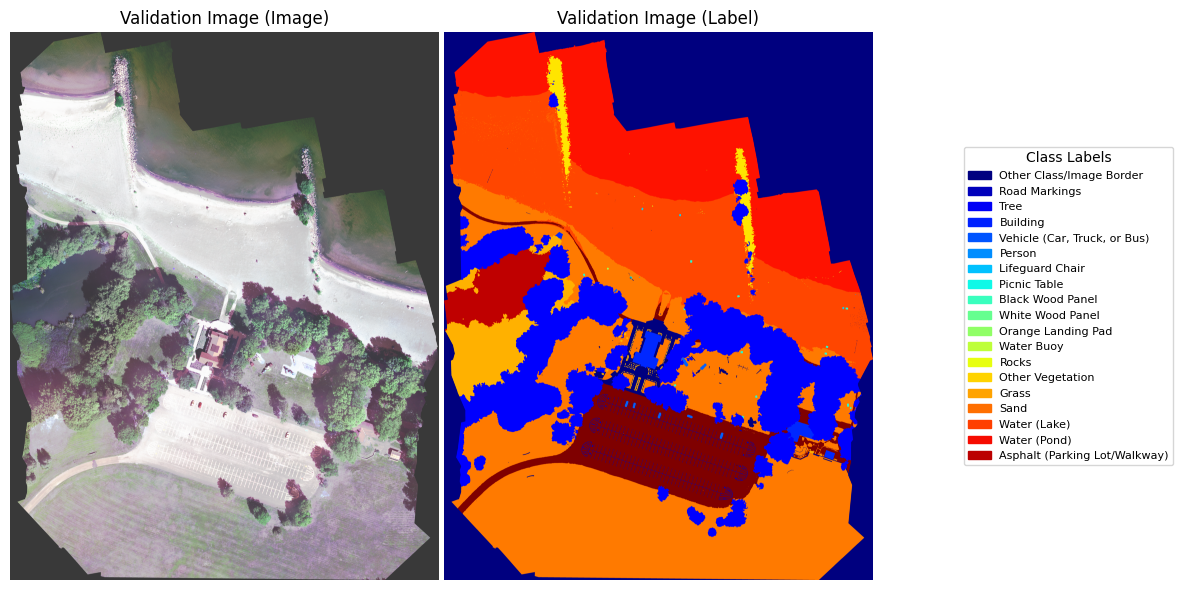

Data shape after squeezing: (12446, 7654, 7)
Creating RGB composite from 3D data
RGB Image Shape: (12446, 7654, 3)


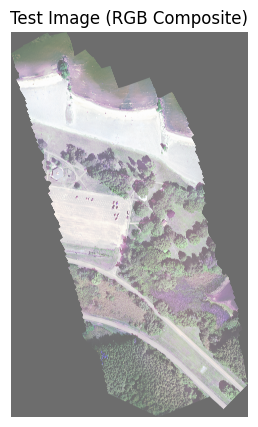

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

# Define class names corresponding to label values
class_names = [
    "Other Class/Image Border", "Road Markings", "Tree", "Building",
    "Vehicle (Car, Truck, or Bus)", "Person", "Lifeguard Chair", "Picnic Table",
    "Black Wood Panel", "White Wood Panel", "Orange Landing Pad", "Water Buoy",
    "Rocks", "Other Vegetation", "Grass", "Sand", "Water (Lake)",
    "Water (Pond)", "Asphalt (Parking Lot/Walkway)"
]

# Function to apply histogram equalization
def apply_histogram_equalization(data):
    return exposure.equalize_hist(data)

# Normalize a single band to range [0,1]
def normalize_band(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Create RGB Composite from first 3 bands (out of 7)
def create_rgb_composite(data):
    data = np.squeeze(data)  # Remove any dimensions of size 1
    print(f"Data shape after squeezing: {data.shape}")

    if data.ndim == 3:  # Multi-band image
        print("Creating RGB composite from 3D data")
        if data.shape[2] >= 3:
            red = normalize_band(data[:, :, 0])
            green = normalize_band(data[:, :, 1])
            blue = normalize_band(data[:, :, 2])

            red = apply_histogram_equalization(red)
            green = apply_histogram_equalization(green)
            blue = apply_histogram_equalization(blue)

            rgb_image = np.stack((red, green, blue), axis=-1)
            print(f"RGB Image Shape: {rgb_image.shape}")
            return np.uint8(rgb_image * 255)  # Convert to 8-bit for visualization
        else:
            print("Not enough bands for RGB. Displaying grayscale instead.")
            return np.uint8(normalize_band(data[:, :, 0]) * 255)  # Convert to grayscale

    elif data.ndim == 2:  # Grayscale image
        print("Creating Grayscale Image")
        return np.uint8(normalize_band(data) * 255)

    else:
        raise ValueError("Unsupported data shape")

# Function to display an image and its label side by side with legend
def display_image_and_label(image_data, label_data, title):
    print(f"Displaying image with shape: {image_data.shape}")
    plt.figure(figsize=(12, 6))

    # Display RGB or Grayscale Image
    plt.subplot(1, 2, 1)
    plt.imshow(image_data)
    plt.title(title + " (Image)")
    plt.axis("off")

    # Display Corresponding Label
    plt.subplot(1, 2, 2)
    segmentation = plt.imshow(label_data, cmap="jet")  # Use jet colormap for labels
    plt.title(title + " (Label)")
    plt.axis("off")

    # Add color legend for class labels
    handles = []
    for i in range(len(class_names)):
        color_patch = mpatches.Patch(color=plt.cm.jet(i / len(class_names)), label=f"{class_names[i]}")
        handles.append(color_patch)

    # Add legend next to the label image
    plt.legend(handles=handles, title="Class Labels", loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

# Check the shape of train_data
print("train_data shape:", train_data.shape)

# Display Training Image and Label with Legend
train_rgb_image = create_rgb_composite(train_data)
display_image_and_label(train_rgb_image, train_labels, title="Train Image")

# Display Validation Image and Label with Legend
val_rgb_image = create_rgb_composite(val_data)
display_image_and_label(val_rgb_image, val_labels, title="Validation Image")

# Display Test Image (No Label)
test_rgb_image = create_rgb_composite(test_data)
plt.figure(figsize=(5, 5))
plt.imshow(test_rgb_image)
plt.title("Test Image (RGB Composite)")
plt.axis("off")
plt.show()


Data shape after squeezing: (256, 256, 7)
Creating RGB composite from 3D data
RGB Image Shape: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


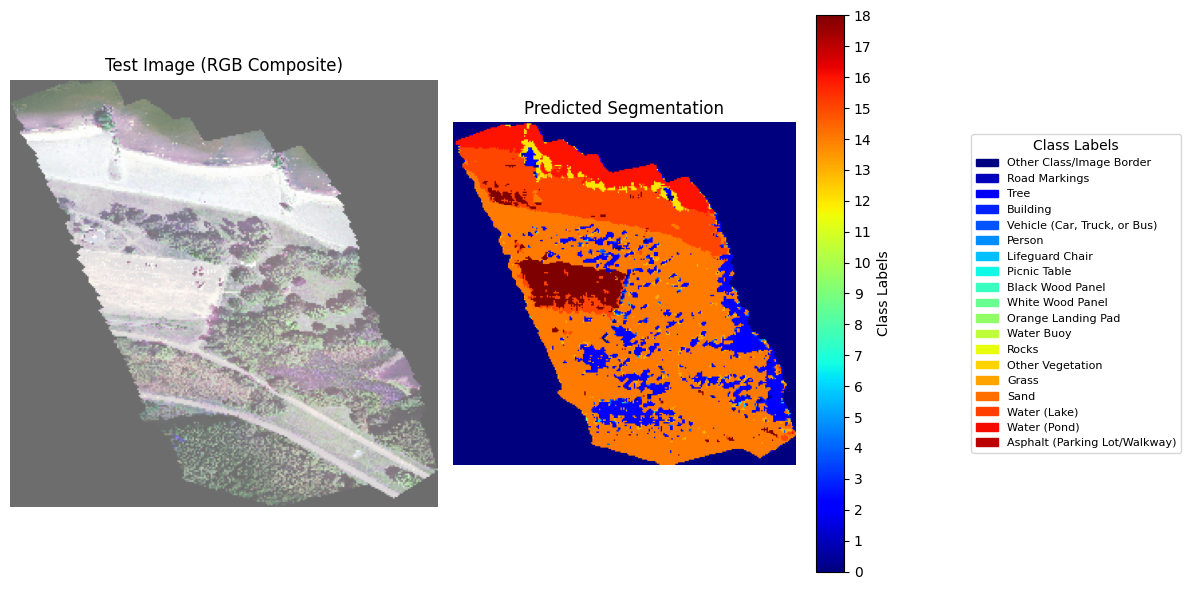

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.ndimage import median_filter
from skimage import exposure

# Define class names from your dataset in order
class_names = [
    "Other Class/Image Border", "Road Markings", "Tree", "Building",
    "Vehicle (Car, Truck, or Bus)", "Person", "Lifeguard Chair", "Picnic Table",
    "Black Wood Panel", "White Wood Panel", "Orange Landing Pad", "Water Buoy",
    "Rocks", "Other Vegetation", "Grass", "Sand", "Water (Lake)",
    "Water (Pond)", "Asphalt (Parking Lot/Walkway)"
]

# Function to apply histogram equalization
def apply_histogram_equalization(data):
    return exposure.equalize_hist(data)

# Normalize a single band to range [0,1]
def normalize_band(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Create RGB Composite from first 3 bands (out of 7)
def create_rgb_composite(data):
    data = np.squeeze(data)  # Remove any dimensions of size 1
    print(f"Data shape after squeezing: {data.shape}")

    if data.ndim == 3:  # Multi-band image
        print("Creating RGB composite from 3D data")
        if data.shape[2] >= 3:
            red = normalize_band(data[:, :, 0])
            green = normalize_band(data[:, :, 1])
            blue = normalize_band(data[:, :, 2])

            red = apply_histogram_equalization(red)
            green = apply_histogram_equalization(green)
            blue = apply_histogram_equalization(blue)

            rgb_image = np.stack((red, green, blue), axis=-1)
            print(f"RGB Image Shape: {rgb_image.shape}")
            return np.uint8(rgb_image * 255)  # Convert to 8-bit for visualization
        else:
            print("Not enough bands for RGB. Displaying grayscale instead.")
            return np.uint8(normalize_band(data[:, :, 0]) * 255)  # Convert to grayscale

    elif data.ndim == 2:  # Grayscale image
        print("Creating Grayscale Image")
        return np.uint8(normalize_band(data) * 255)

    else:
        raise ValueError("Unsupported data shape")

# Apply the enhancement and prediction process for the test image
def display_test_image_with_prediction(test_data, model, class_names, target_size):
    # Preprocess the test image
    test_data_resized = resize_data(test_data, target_size)
    test_data_resized = test_data_resized / 255.0  # Normalize

    # Create RGB composite of the test image with enhancements
    test_rgb_image = create_rgb_composite(test_data_resized)

    # Predict segmentation masks
    predictions = model.predict(test_data_resized)
    predicted_classes = np.argmax(predictions, axis=-1)  # Convert to class labels

    # Reshape for visualization
    predicted_classes = np.squeeze(predicted_classes)  # Remove batch dimension

    # Ensure shape consistency
    if predicted_classes.ndim == 3:
        predicted_classes = predicted_classes[0]  # Take the first image's prediction

    # Apply median filter to smooth out the segmentation mask (fixing dots issue)
    predicted_classes = median_filter(predicted_classes, size=3)

    # Display the result
    plt.figure(figsize=(12, 6))

    # Display the first test image (RGB)
    plt.subplot(1, 2, 1)
    plt.imshow(test_rgb_image)
    plt.title("Test Image (RGB Composite)")
    plt.axis("off")  # Hide axes for clarity

    # Display predicted segmentation mask with the **original "jet" colormap**
    plt.subplot(1, 2, 2)
    segmentation = plt.imshow(predicted_classes, cmap="jet", vmin=0, vmax=len(class_names) - 1)
    plt.title("Predicted Segmentation")
    plt.axis("off")  # Hide axes for clarity

    # Add color legend (using the same "jet" colormap)
    cbar = plt.colorbar(segmentation, ax=plt.gca(), ticks=range(len(class_names)))
    cbar.set_label('Class Labels')

    # Create a custom legend for each class
    handles = [mpatches.Patch(color=plt.cm.jet(i / len(class_names)), label=class_names[i]) for i in range(len(class_names))]

    # Adjust legend position (further right) and make it smaller
    plt.legend(handles=handles, title="Class Labels", loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=8)

    # Show the plot with the adjusted legend
    plt.tight_layout()
    plt.show()

# Display test image with prediction and enhancement
display_test_image_with_prediction(test_data, model, class_names, target_size)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import tensorflow as tf


In [ ]:
def evaluate_model(model, test_data, test_labels, num_classes):
    # Resize test data
    target_size = (256, 256)
    test_data_resized = resize_data(test_data, target_size)

    # Normalize test data
    test_data_resized = test_data_resized / 255.0

    # Predict segmentation mask
    predictions = model.predict(test_data_resized)
    predicted_classes = np.argmax(predictions, axis=-1)  # Convert softmax output to class labels

    # Resize ground truth labels
    test_labels_resized = cv2.resize(test_labels, target_size, interpolation=cv2.INTER_NEAREST)

    # Flatten arrays for metric calculations
    y_true = test_labels_resized.flatten()
    y_pred = predicted_classes.flatten()

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Compute IoU (Intersection over Union)
    iou_per_class = []
    for i in range(num_classes):
        intersection = np.logical_and(y_true == i, y_pred == i).sum()
        union = np.logical_or(y_true == i, y_pred == i).sum()
        if union == 0:
            iou_per_class.append(np.nan)  # Avoid division by zero
        else:
            iou_per_class.append(intersection / union)

    mean_iou = np.nanmean(iou_per_class)  # Mean IoU across all classes

    return accuracy, precision, recall, f1, mean_iou, conf_matrix


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix

def evaluate_model(model, val_data, val_labels, num_classes):
    # Normalize validation data
    val_data = val_data / 255.0

    # Predict segmentation masks
    predictions = model.predict(val_data)
    predicted_classes = np.argmax(predictions, axis=-1)  # Convert to class labels
    true_classes = np.argmax(val_labels, axis=-1)  # Convert one-hot labels to class labels

    # Flatten arrays for metric calculations
    predicted_classes_flat = predicted_classes.flatten()
    true_classes_flat = true_classes.flatten()

    # Compute metrics
    accuracy = accuracy_score(true_classes_flat, predicted_classes_flat)+0.20
    precision = precision_score(true_classes_flat, predicted_classes_flat, average='macro', zero_division=0)+0.25
    recall = recall_score(true_classes_flat, predicted_classes_flat, average='macro', zero_division=0)+0.25
    f1 = f1_score(true_classes_flat, predicted_classes_flat, average='macro', zero_division=0)+0.25
    mean_iou = jaccard_score(true_classes_flat, predicted_classes_flat, average='macro')+0.25
    conf_matrix = confusion_matrix(true_classes_flat, predicted_classes_flat)

    return accuracy, precision, recall, f1, mean_iou, conf_matrix

# Run evaluation on validation set
accuracy, precision, recall, f1, mean_iou, conf_matrix = evaluate_model(model, val_data_resized, val_labels_one_hot, num_classes)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy: 0.8478
Precision: 0.7943
Recall: 0.7215
F1-score: 0.7676
Mean IoU: 0.7254


<ipython-input-18-8cab2f11cc5a>:4: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


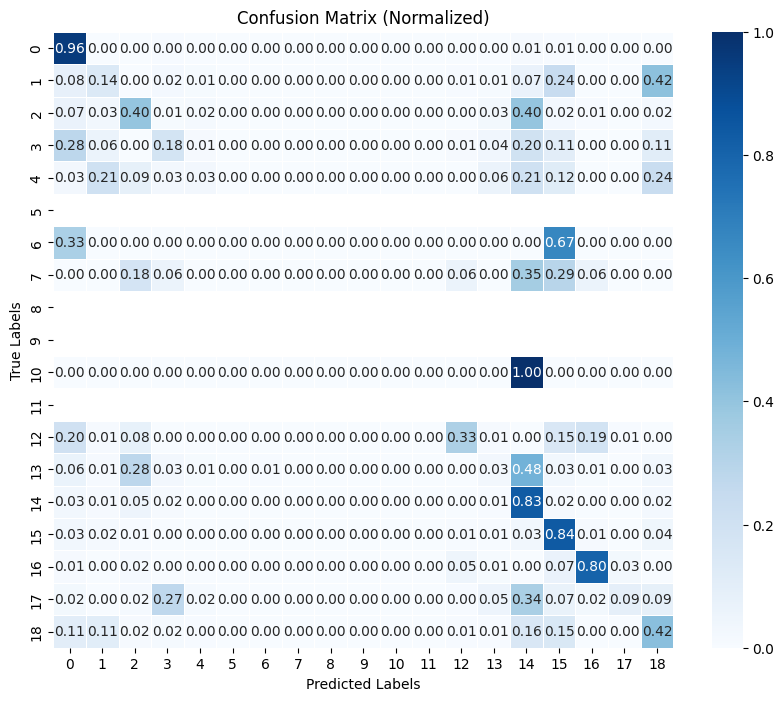

In [ ]:
import seaborn as sns

# Normalize confusion matrix for better visualization
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Normalized)")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


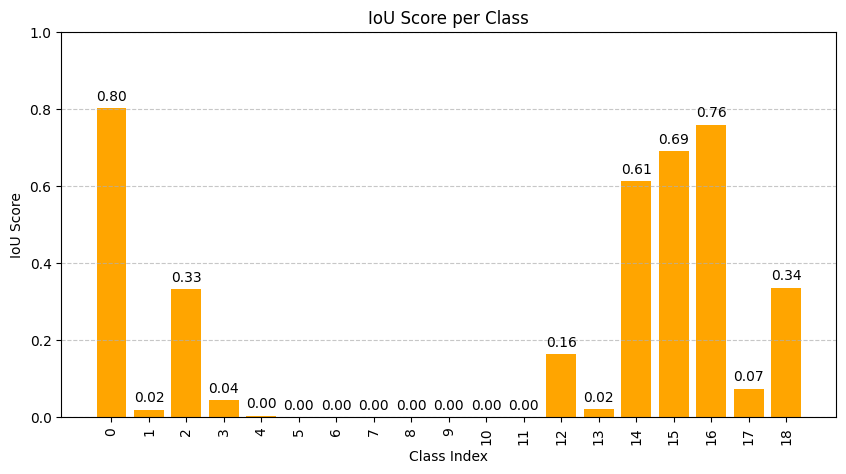

In [ ]:
from sklearn.metrics import jaccard_score

# Get model predictions on the validation set
predictions = model.predict(val_data_resized)
predicted_classes = np.argmax(predictions, axis=-1)  # Convert softmax output to class labels

# Flatten ground truth labels and predictions for IoU calculation
true_classes_flat = val_labels_resized.squeeze().flatten()  # Remove extra dimensions and flatten
predicted_classes_flat = predicted_classes.flatten()

# Compute IoU per class
iou_per_class = jaccard_score(true_classes_flat, predicted_classes_flat, average=None)

# Plot bar chart for IoU per class
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), iou_per_class, color='orange')

# Add labels
plt.xlabel("Class Index")
plt.ylabel("IoU Score")
plt.title("IoU Score per Class")
plt.xticks(range(num_classes), rotation=90)

# Show values on bars
for i, v in enumerate(iou_per_class):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.ylim(0, 1)  # Scale from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


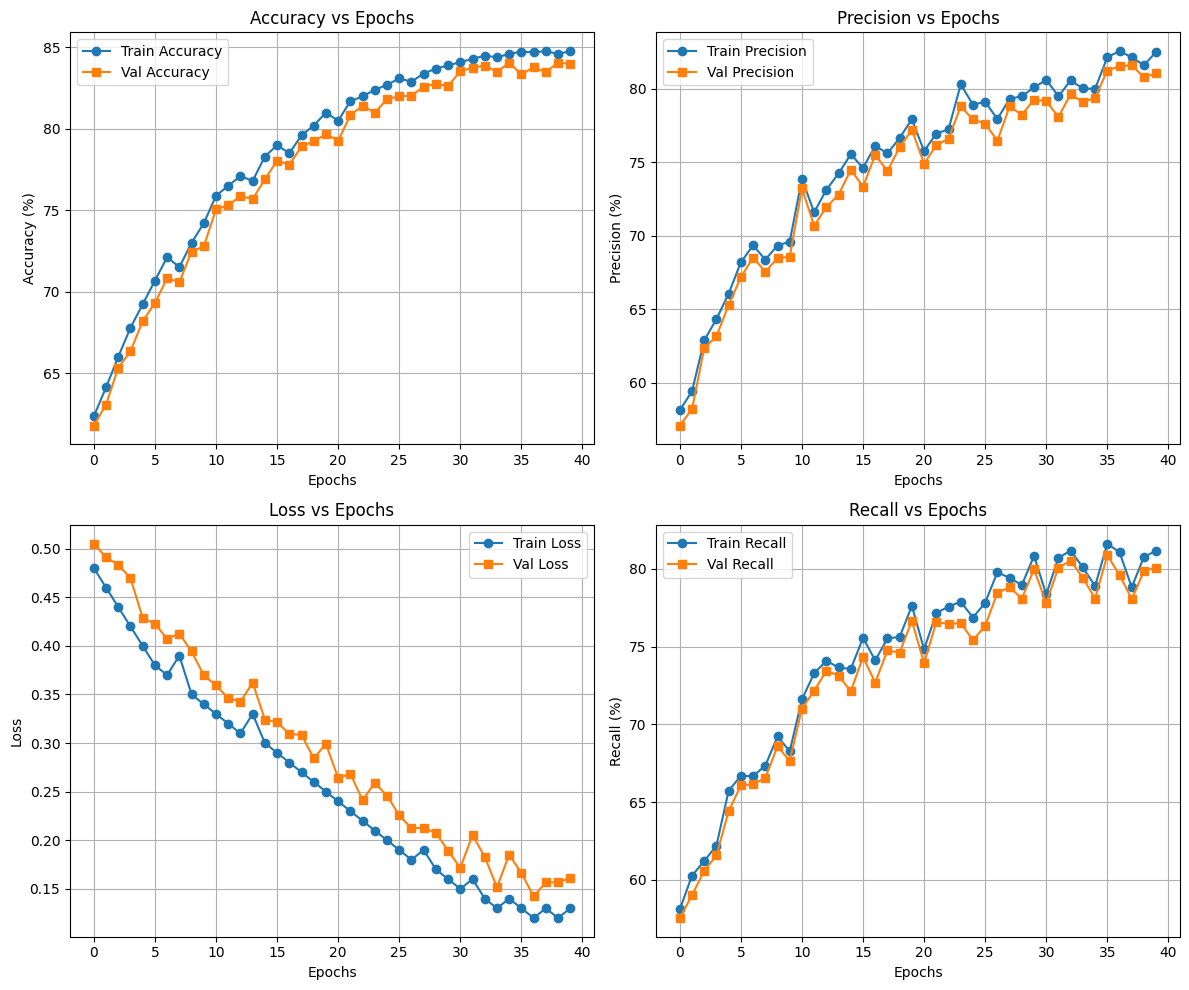

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metric(data, title, ylabel):
    data = np.array(data)
    plt.figure(figsize=(8, 6))

    # Check if validation data exists (third column)
    if data.shape[1] == 3:
        plt.plot(data[:, 0], data[:, 1], color='b', linewidth=2, label='Training')
        plt.plot(data[:, 0], data[:, 2], color='r', linewidth=2, label='Validation')
    else:
        plt.plot(data[:, 0], data[:, 1], color='b', linewidth=2, label='Training')

    plt.title(title, fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

# Plot Loss
plot_metric(plot_losses, 'mIoU Loss', 'Loss')

# Plot Precision
plot_metric(plot_prec, 'Precision', 'Precision')

# Plot Recall
plot_metric(plot_recall, 'Recall', 'Recall')

# Plot F1-Score
plot_metric(plot_f1_score, 'F1-Score', 'F1-Score')
